В данной реализации я не прибегал к скрупулезной очистке данных и подробному анализу. Это учебный датасет, в котором не хватает к примеру координат для парсинга расстояния до ближайших линий общественного трансопорта, объектов инфраструктуры и т.д. Цель - попытаться извлечь максимум пользы из уже имеющихся данных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
import catboost
from catboost import Pool
import seaborn as sns


%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams.update({'font.size' : 10})
sns.set(rc={"figure.figsize": (6, 4)})

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train = train.drop('Id', axis = 1)
test_wId = test
test = test.drop('Id', axis= 1)

#### Выведем новый признак на основе DistrictId

In [3]:
price_dist_median = train.groupby('DistrictId')[['Price']].median().reset_index()

train = pd.merge(train,price_dist_median, how = 'left', on = 'DistrictId')
train.rename(columns = {'Price_x' : 'Price', 'Price_y' : 'Dist_Price'}, inplace = True)

test = pd.merge(test,price_dist_median, how = 'left', on = 'DistrictId')
test.rename(columns = {'Price' : 'Dist_Price'}, inplace = True)
# В train есть не все районы, которые находятся в test, поэтому при мердже появилось несколько пропусков
# Их не много, заполним нулевой модой
test['Dist_Price'] = test['Dist_Price'].fillna(test['Dist_Price'].mode()[0])
test.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Dist_Price
0,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B,151557.904767
1,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,195610.960042
2,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B,526438.458919
3,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B,196429.659238
4,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A,146171.433190


#### Удалим Healthcare_1

In [4]:
train.drop(columns='Healthcare_1', inplace=True)
test.drop(columns='Healthcare_1', inplace=True)

#### Square & Lifesquare & KitchenSquare

In [5]:
# 0.8 - произвольный коэффициент для соразмерности прощадей
train.LifeSquare = train.LifeSquare.fillna(train.LifeSquare.mean())
train.loc[train['Square'] > 600, 'Square'] = train['Square'].median()
train.loc[train['Square'] < train['LifeSquare'], 'LifeSquare'] = train.Square * 0.8
train.loc[(train['KitchenSquare'] == 0) | (train['KitchenSquare'] > train['LifeSquare']), 'KitchenSquare'] = train.Square - train.LifeSquare

test.LifeSquare = test.LifeSquare.fillna(test.LifeSquare.mean())
test.loc[test['Square'] < test['LifeSquare'], 'LifeSquare'] = test.Square * 0.8
test.loc[(test['KitchenSquare'] == 0) | (test['KitchenSquare'] > test['LifeSquare']), 'KitchenSquare'] = test.Square - test.LifeSquare

#### Rooms

In [6]:
train.loc[(train['Square'] < 100), 'Rooms'] = 1
train.loc[(train['Square'] >= 100), 'Rooms'] = 2

test.loc[(test['Square'] < 100), 'Rooms'] = 1
test.loc[(test['Square'] >= 100), 'Rooms'] = 2

#### HouseYear

In [7]:
train.loc[train['HouseYear'] > 2021, 'HouseYear'] = train.HouseYear.median()
test.loc[test['HouseYear'] > 2021, 'HouseYear'] = test.HouseYear.median()

#### Room / S

In [8]:
train['S / Room'] = (train['Square']/train['Rooms']).astype('float64')
test['S / Room'] = (test['Square']/test['Rooms']).astype('float64')

In [9]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,209.000000
Rooms,10000.0,1.026000,0.159143,1.000000,1.000000,1.000000,1.000000,2.000000
Square,10000.0,56.201701,19.472731,1.136859,41.774881,52.513040,65.890819,409.425181
LifeSquare,10000.0,35.577602,15.060492,0.370619,25.165748,36.458969,40.341931,327.540145
KitchenSquare,10000.0,7.174520,7.428518,0.021395,1.000000,7.000000,9.000000,132.817227
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,42.000000
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,117.000000
HouseYear,10000.0,1984.863800,18.409979,1910.000000,1974.000000,1977.000000,2001.000000,2020.000000
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,0.521867
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,74.000000


In [10]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
DistrictId,5000.0,51.279200,44.179466,0.000000,21.000000,37.000000,77.000000,212.000000
Rooms,5000.0,1.026200,0.159746,1.000000,1.000000,1.000000,1.000000,2.000000
Square,5000.0,56.449500,19.092787,1.378543,41.906231,52.921340,66.285129,223.453689
LifeSquare,5000.0,35.366952,14.313447,0.333490,25.331777,36.158810,40.669771,136.921090
KitchenSquare,5000.0,7.115745,7.132827,0.058925,3.000000,6.000000,9.000000,122.041783
Floor,5000.0,8.632000,5.483228,1.000000,4.000000,7.000000,12.000000,78.000000
HouseFloor,5000.0,12.601000,6.789213,0.000000,9.000000,12.000000,17.000000,99.000000
HouseYear,5000.0,1984.392600,18.573149,1908.000000,1973.000000,1977.000000,2000.000000,2020.000000
Ecology_1,5000.0,0.119874,0.120070,0.000000,0.019509,0.072158,0.195781,0.521867
Social_1,5000.0,24.933800,17.532202,0.000000,6.000000,25.000000,36.000000,74.000000


### PCA

In [11]:
important = ['Square','Dist_Price','S / Room']
n = 2
names = ['pca_' + str(i+1) for i in range(n)]

In [12]:
pca = PCA(n_components=n)

train_components = pca.fit_transform(train[important])
train_components = pd.DataFrame(data=train_components, columns=names)
train = pd.concat([train, train_components], axis=1)
train_components.head()
train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Dist_Price,S / Room,pca_1,pca_2
0,35,1.0,47.981561,29.442751,6.000000,7,9.0,1969.0,0.089040,B,...,7976,5,0,11,B,184966.930730,203602.408898,47.981561,1686.195066,-10.629523
1,41,1.0,65.683640,40.049543,8.000000,7,9.0,1978.0,0.000070,B,...,10309,1,1,16,B,300009.450063,210694.850106,65.683640,8778.637042,14.020018
2,53,1.0,44.947953,29.197612,15.750341,8,12.0,1968.0,0.049637,B,...,7759,0,1,3,B,220925.908524,245978.794474,44.947953,44062.580489,-16.210408
3,58,1.0,53.352981,52.731512,9.000000,8,17.0,1977.0,0.437885,B,...,5735,3,0,5,B,175616.227217,151557.904767,53.352981,-50358.308806,-1.463266
4,99,1.0,39.649192,23.776169,7.000000,11,12.0,1976.0,0.012339,B,...,5776,1,2,4,B,150226.531644,178829.166450,39.649192,-23087.047733,-21.564956


In [13]:
pca = PCA(n_components=n)

test_components = pca.fit_transform(test[important])
test_components = pd.DataFrame(data=test_components, columns=names)
test = pd.concat([test, test_components], axis=1)
test_components.head()
test.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Dist_Price,S / Room,pca_1,pca_2
0,58,1.0,49.882643,33.432782,6.000000,6,14.0,1972.0,0.310199,B,...,11,2748,1,0,0,B,151557.904767,49.882643,-50523.812745,-7.496229
1,74,1.0,69.263183,36.158810,1.000000,6,1.0,1977.0,0.075779,B,...,6,1437,3,0,2,B,195610.960042,69.263183,-6470.757062,19.098203
2,190,1.0,13.597819,10.878255,2.719564,2,5.0,1909.0,0.000000,B,...,30,7538,87,5,5,B,526438.458919,13.597819,324356.740589,-64.254932
3,47,1.0,73.046609,51.940842,9.000000,22,22.0,2007.0,0.101872,B,...,23,4583,3,3,3,B,196429.659238,73.046609,-5652.057785,24.408455
4,27,1.0,47.527111,43.387569,1.000000,17,17.0,2017.0,0.072158,B,...,2,629,1,0,0,A,146171.433190,47.527111,-55910.284372,-10.728055


### Dummies

In [14]:
X = pd.get_dummies(train)
X.drop("Price", axis=1, inplace=True)
y = train['Price']

In [15]:
X_test = pd.get_dummies(test)

### Нормализуем и разобьем на train test

In [16]:
scaler = StandardScaler()

In [17]:
features = X.select_dtypes(include = ['float64','int64']).columns.to_list()
X[features] = scaler.fit_transform(X[features])
X_test[features] = scaler.transform(X_test[features])

In [18]:
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.3, random_state = 42)

Общая модель может обучаться дольше чем обычно, у меня весь ноутбук отрабатывает не более 2х минут.
Данная комбинация дает +0.02 относительно каждой по одиночке

In [19]:
mod_1 = GradientBoostingRegressor(n_estimators=400, max_depth=5, min_samples_split=2,
                                           learning_rate=0.1, loss='ls', random_state=42)

mod_2 = RandomForestRegressor(n_estimators=1442, max_depth=5, random_state=42, max_features=10)

mod_3 = catboost.CatBoostRegressor(silent = True ,learning_rate=0.1,depth=5,l2_leaf_reg=0.01)

model = VotingRegressor([('model_1', mod_1), ('model_2', mod_2),('model_3', mod_3)])

Графики голосования.

Долго, но красиво)

In [20]:
xt = X_train[:20]

mod_1.fit(X_train, y_train)
mod_2.fit(X_train, y_train)
mod_3.fit(X_train, y_train)
model.fit(X_train, y_train)

pred1 = mod_1.predict(xt)
pred2 = mod_2.predict(xt)
pred3 = mod_3.predict(xt)
pred4 = model.predict(xt)

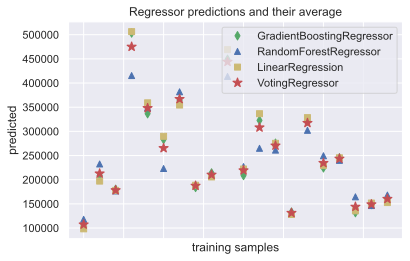

In [21]:
plt.figure()
plt.plot(pred1, 'gd', label='GradientBoostingRegressor')
plt.plot(pred2, 'b^', label='RandomForestRegressor')
plt.plot(pred3, 'ys', label='LinearRegression')
plt.plot(pred4, 'r*', ms=10, label='VotingRegressor')

plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Regressor predictions and their average')

plt.show()

In [22]:
model.fit(X_train,y_train)

VotingRegressor(estimators=[('model_1',
                             GradientBoostingRegressor(max_depth=5,
                                                       n_estimators=400,
                                                       random_state=42)),
                            ('model_2',
                             RandomForestRegressor(max_depth=5, max_features=10,
                                                   n_estimators=1442,
                                                   random_state=42)),
                            ('model_3',
                             <catboost.core.CatBoostRegressor object at 0x0000020B7FFB1160>)])

In [23]:
y_test_pred = model.predict(X_valid)

В задачах такого рода приятно ориентироваться на R2(Грубо говоря, он показывает % изменчивости, который описывает наша модель)

При сабмите на kaggle он может быть как выше, так и ниже.

In [24]:
r2_score(y_valid,y_test_pred)

0.7407170511272756

Обучим модель на всем датасете

In [25]:
model.fit(X,y)

VotingRegressor(estimators=[('model_1',
                             GradientBoostingRegressor(max_depth=5,
                                                       n_estimators=400,
                                                       random_state=42)),
                            ('model_2',
                             RandomForestRegressor(max_depth=5, max_features=10,
                                                   n_estimators=1442,
                                                   random_state=42)),
                            ('model_3',
                             <catboost.core.CatBoostRegressor object at 0x0000020B7FFB1160>)])

In [26]:
y_pred = model.predict(X_test)

In [27]:
test_wId['Price'] = y_pred
test_wId[['Id','Price']].to_csv('voting_predictions.csv', index = False)